# Self-optimizing ML: A Simple Case illustration


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")
from sklearn import datasets

In [2]:
X, y = datasets.make_hastie_10_2(n_samples=20000, random_state=1)

In [3]:
df=pd.DataFrame(data=X,columns=['X'+str(i) for i in range(1,11)])
df['y']=pd.Series(y)
df.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,y
0,1.624345,-0.611756,-0.528172,-1.072969,0.865408,-2.301539,1.744812,-0.761207,0.319039,-0.249370,1.0
1,1.462108,-2.060141,-0.322417,-0.384054,1.133769,-1.099891,-0.172428,-0.877858,0.042214,0.582815,1.0
2,-1.100619,1.144724,0.901591,0.502494,0.900856,-0.683728,-0.122890,-0.935769,-0.267888,0.530355,-1.0
3,-0.691661,-0.396754,-0.687173,-0.845206,-0.671246,-0.012665,-1.117310,0.234416,1.659802,0.742044,-1.0
4,-0.191836,-0.887629,-0.747158,1.692455,0.050808,-0.636996,0.190915,2.100255,0.120159,0.617203,1.0


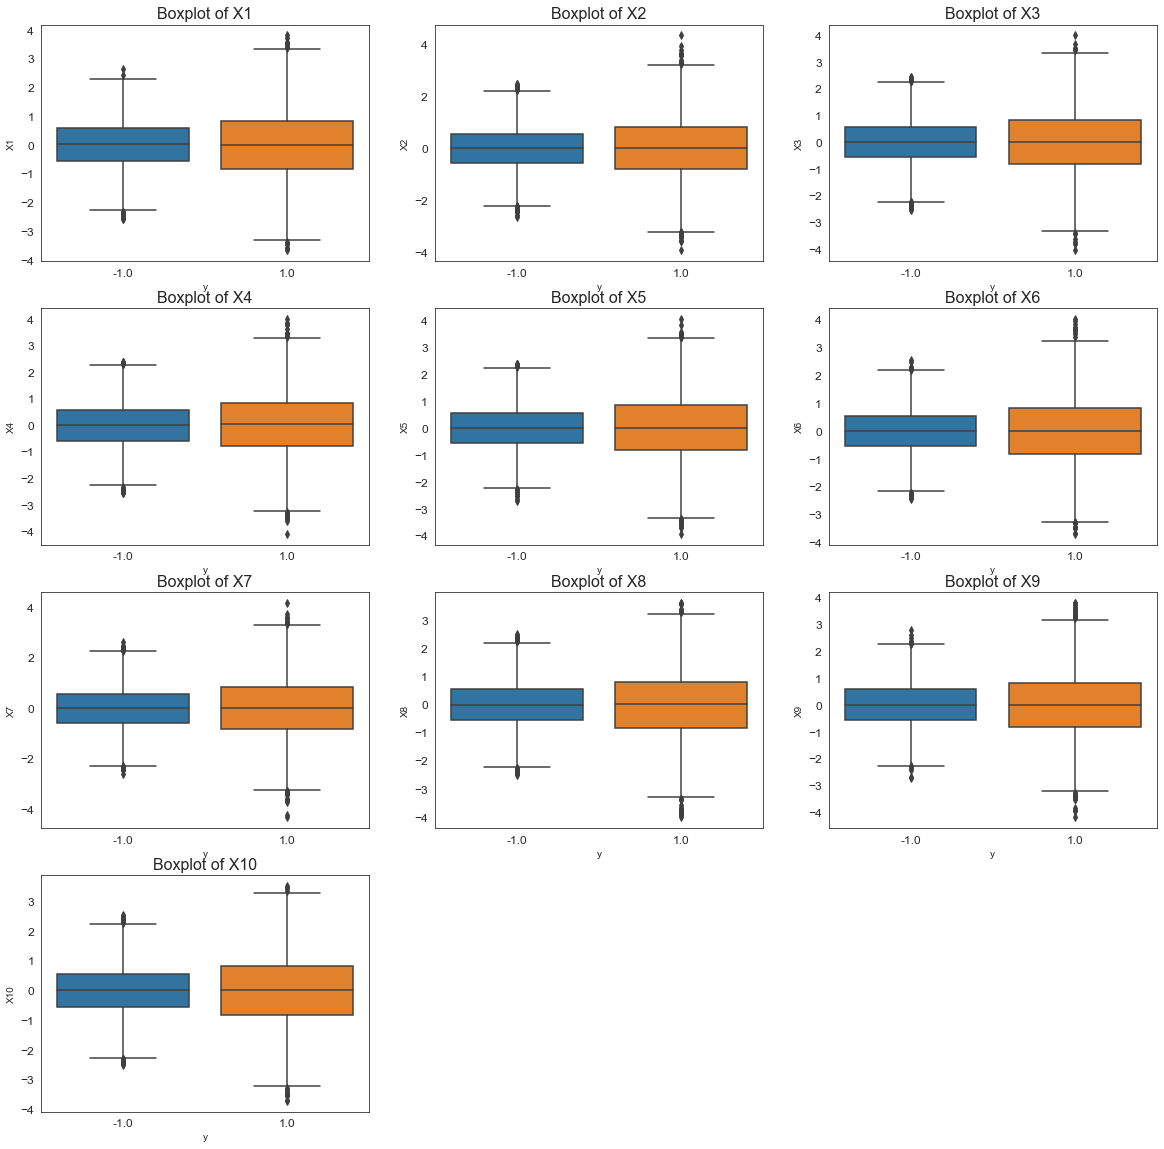

In [4]:
i=1
plt.figure(figsize=(20,20))
for c in df.columns[:-1]:
    plt.subplot(4,3,i)
    plt.title(f"Boxplot of {c}",fontsize=16)
    plt.yticks(fontsize=12)
    plt.xticks(fontsize=12)
    sns.boxplot(y=df[c],x=df['y'])
    i+=1
plt.show()

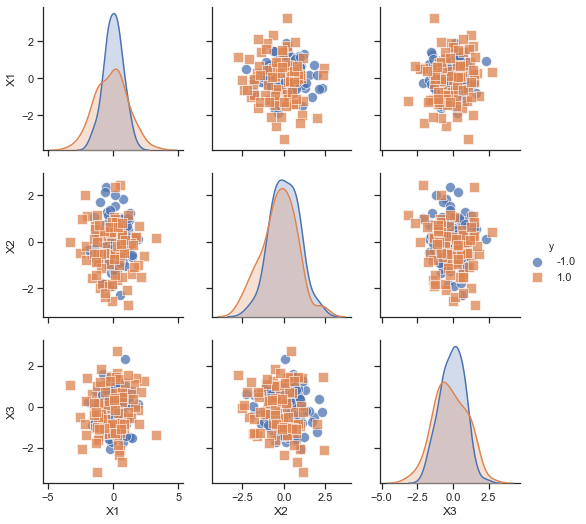

In [5]:
df_sample=df.sample(frac=0.01)
sns.set(style="ticks")
g=sns.pairplot(df_sample,vars=["X1","X2","X3"],
               hue="y",markers=["o", "s"],
               diag_kind="kde",diag_kws=dict(shade=True),plot_kws=dict(s=100,alpha=0.75))

# Data preparation and test/train split

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
X=df.drop('y',axis=1)
y=df['y']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

In [9]:
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.50)

In [10]:
print("Shape of validation set:", X_val.shape)
print("Shape of test set:", X_test.shape)
print("Shape of training set:", X_train.shape)

Shape of validation set: (3000, 10)
Shape of test set: (3000, 10)
Shape of training set: (14000, 10)


# Classification algorithms and the metrics - accuracy_score and f1_score

In [11]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

### Run the classification over a range of trees in the AdaBoost meta-estimator and record accuracy and compute time

In [12]:
import time
val_acc_num_trees=[]
val_f1_num_trees=[]
train_acc_num_trees=[]
train_f1_num_trees=[]
time_adaboost=[]
val_range=(1,21,1)
for i in range(val_range[0],val_range[1],val_range[2]):
    t1=time.time()
    # Fitting
    adaboost = AdaBoostClassifier(DecisionTreeClassifier(min_samples_leaf=20,max_depth=2),
                            n_estimators=i,learning_rate=0.2)
    adaboost.fit(X_train,y_train)
    pred_train = adaboost.predict(X_train)
    pred_val = adaboost.predict(X_val)
    # Accuracy and F1 score
    acc_train=accuracy_score(y_train,pred_train)
    f1_train = f1_score(y_train,pred_train,average='micro')
    acc_val=accuracy_score(y_val,pred_val)
    f1_val = f1_score(y_val,pred_val,average='micro')
    # Appending to the lists
    train_acc_num_trees.append(acc_train)
    train_f1_num_trees.append(f1_train)
    val_acc_num_trees.append(acc_val)
    val_f1_num_trees.append(f1_val)
    t2=time.time()
    time_adaboost.append(t2-t1)
    print(f"Done for number of trees: {i}")

Done for number of trees: 1
Done for number of trees: 2
Done for number of trees: 3
Done for number of trees: 4
Done for number of trees: 5
Done for number of trees: 6
Done for number of trees: 7
Done for number of trees: 8
Done for number of trees: 9
Done for number of trees: 10
Done for number of trees: 11
Done for number of trees: 12
Done for number of trees: 13
Done for number of trees: 14
Done for number of trees: 15
Done for number of trees: 16
Done for number of trees: 17
Done for number of trees: 18
Done for number of trees: 19
Done for number of trees: 20


# Plots of accuracy and compute time

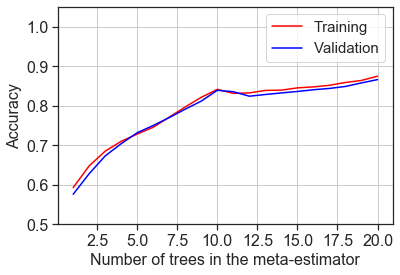

In [13]:
plt.plot(range(val_range[0],val_range[1],val_range[2]),train_acc_num_trees,c='red')
plt.plot(range(val_range[0],val_range[1],val_range[2]),val_acc_num_trees,c='blue')
plt.legend(["Training","Validation"],fontsize=15)
plt.grid(True)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("Number of trees in the meta-estimator", fontsize=16)
plt.ylabel("Accuracy",fontsize=16)
plt.ylim(0.5,1.05)
plt.show()

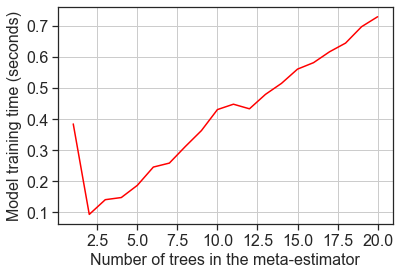

In [14]:
plt.plot(range(val_range[0],val_range[1],val_range[2]),time_adaboost,c='red')
plt.grid(True)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("Number of trees in the meta-estimator", fontsize=16)
plt.ylabel("Model training time (seconds)",fontsize=16)
#plt.ylim(0.7,1.05)
plt.show()

# A simple linear objective function for the business-centric optimization
### The optimization (objective function) looks like following,
                        
                                            objective = alpha.(v-v_th/v_max)+beta.(t-t_max)

### Here, v denotes the validation set accuracy and t denotes the compute time. Note the use of v_th as a threshold value only above which the accuracy matters.

In [15]:
v = np.array(val_acc_num_trees)
t = np.array(time_adaboost)

In [16]:
v_th = 0.5

In [17]:
v=(v-v_th)/v.max()
t=t/t.max()

In [18]:
alpha = 3
beta = 1

In [19]:
o = alpha*v-beta*(t)

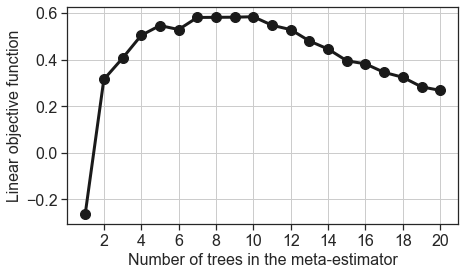

In [20]:
plt.figure(figsize=(7,4))
plt.plot(range(val_range[0],val_range[1],val_range[2]),o,color='k',marker='o',lw=3,markersize='10')
plt.grid(True)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("Number of trees in the meta-estimator", fontsize=16)
plt.ylabel("Linear objective function",fontsize=16)
plt.xticks([i for i in range(2,21,2)])
plt.show()

# Constructing the objective function formally for Scipy run

In [21]:
def objective(x, v_th=0.5,alpha=3,beta=1):
    """
    Objective function computing a overall cost function
    involving the running time and performance of the AdaBoost classifier fitting
    x: number of trees to be used by the meta-estimator (AdaBoost)
    V_th: Minimum accuracy threshold
    alpha: Cost factor of the accuracy (indicator of profit)
    beta: Cost factor of running time (indicator of expense)
    """ 
    x = int(x)
    if x<1:
        x=1
    t1=time.time()
    # Fitting
    adaboost = AdaBoostClassifier(DecisionTreeClassifier(min_samples_leaf=20,max_depth=2),
                            n_estimators=x,learning_rate=0.2)
    adaboost.fit(X_train,y_train)
    t2=time.time()
    pred_train = adaboost.predict(X_train)
    pred_val = adaboost.predict(X_val)
    # Accuracy and F1 score
    acc_train=accuracy_score(y_train,pred_train)
    f1_train = f1_score(y_train,pred_train,average='micro')
    acc_val=accuracy_score(y_val,pred_val)
    f1_val = f1_score(y_val,pred_val,average='micro')
    
    v = acc_val # Validation set accuracy
    t = t2-t1 # Time taken for fitting and calculating the accuracy
    
    # Normalize the accuracy and time measures
    #v=(v-v_th)/v.max()
    #t=t/t.max()
    
    # Objective function (a profit measure)
    obj = alpha*v-beta*(t)
    
    return -float(obj)

In [22]:
for i in range(1,21):
    print(objective(i,0.5,5,1),end=', ')

-2.8470193195343017, -3.077553644180298, -3.2712759876251223, -3.379767913818359, -3.4865017255147297, -3.540795087814331, -3.5954302310943604, -3.689673859278361, -3.7595755418141685, -3.8473470878601077, -3.8092180983225505, -3.71989595413208, -3.6937532583872477, -3.6800582758585616, -3.678211860656738, -3.668343140284221, -3.651087134679159, -3.64159654935201, -3.639935887654622, -3.647265748977661, 

In [23]:
n=np.arange(1,21)

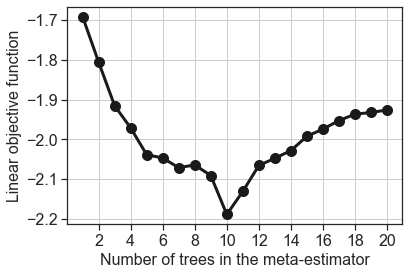

In [24]:
plt.plot(n,list(map(objective,n)),color='k',marker='o',lw=3,markersize='10')
plt.grid(True)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("Number of trees in the meta-estimator", fontsize=16)
plt.ylabel("Linear objective function",fontsize=16)
plt.xticks([i for i in range(2,21,2)])
plt.show()

# Calling minimize_scalar from Scipy
For a detailed discussion on Scipy optimization functions see this article on Medium:

"Optimization with SciPy and application ideas to machine learning"

In [25]:
from scipy.optimize import minimize_scalar

In [26]:
r=minimize_scalar(objective,bounds=(2,21),options={'disp':True},method='Bounded')


Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  1e-05 )


In [27]:
r.items()

dict_items([('fun', -2.1889887256622313), ('status', 0), ('success', True), ('message', 'Solution found.'), ('x', 10.635723006883886), ('nfev', 31)])

## For various datasets

In [28]:

def objective_dataset(x, X_train,y_train,X_val,y_val,v_th=0.5,alpha=3,beta=1):
    """
    Objective function computing a overall cost function
    involving the running time and performance of the AdaBoost classifier fitting
    x: number of trees to be used by the meta-estimator (AdaBoost)
    V_th: Minimum accuracy threshold
    alpha: Cost factor of the accuracy (indicator of profit)
    beta: Cost factor of running time (indicator of expense)
    """ 
    x = int(x)
    if x<1:
        x=1
    t1=time.time()
    # Fitting
    adaboost = AdaBoostClassifier(DecisionTreeClassifier(min_samples_leaf=20,max_depth=2),
                            n_estimators=x,learning_rate=0.2)
    adaboost.fit(X_train,y_train)
    t2=time.time()
    pred_train = adaboost.predict(X_train)
    pred_val = adaboost.predict(X_val)
    # Accuracy and F1 score
    acc_train=accuracy_score(y_train,pred_train)
    f1_train = f1_score(y_train,pred_train,average='micro')
    acc_val=accuracy_score(y_val,pred_val)
    f1_val = f1_score(y_val,pred_val,average='micro')
    
    v = acc_val # Validation set accuracy
    t = t2-t1 # Time taken for fitting and calculating the accuracy
    
    # Normalize the accuracy and time measures
    #v=(v-v_th)/v.max()
    #t=t/t.max()
    
    # Objective function (a profit measure)
    obj = alpha*v-beta*(t)
    
    return -float(obj)

In [29]:
for _ in range(5):
    X, y = datasets.make_hastie_10_2(n_samples=2000, random_state=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)
    X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.50)
    result=minimize_scalar(objective_dataset,bounds=(2,20),args=(X_train,y_train,X_val,y_val),method='Bounded')
    print(result['x'])
    print("-"*15)

13.324318934226046
---------------
15.285191825121503
---------------
13.121161634041995
---------------
13.10059122410626
---------------
13.210625693514089
---------------
